In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from astroML.utils import completeness_contamination
from sklearn.metrics import precision_recall_curve, roc_curve
import h5py
from sklearn.tree import DecisionTreeClassifier 
import sklearn.model_selection

In [2]:
f = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')
#con dati così grandi non posso fare plt.plot, posso fare histo

In [3]:
f.keys()

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>

In [4]:
det=f['det'][:]
det=det[:int(1e5)]
print(len(det))
#det=np.array(det)


100000


In [5]:
dati=[]
for lab in['chi1x', 'chi1y', 'chi1z','chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra','z']:
    dati.append(f[lab][:int(1e5)])

In [6]:
dati=np.array(dati) 
dati=dati.T 
print(dati.shape)

(100000, 13)


In [7]:
sources=det[det==1]
noise=det[det==0]
print("numero di oggetti detectable", len(sources))
print("numero di oggetti NON detectable", len(noise))
print(len(sources)/len(noise))
#così vedoche le due classi sono molto sproporzionate

numero di oggetti detectable 14382
numero di oggetti NON detectable 85618
0.1679786960685837


In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

dati_stand = scaler.fit_transform(dati)

dati_stand_train, dati_stand_test, det_s_train, det_s_test=train_test_split(dati_stand,det, train_size=0.67, random_state=42)

dati_train, dati_test, det_train, det_test=train_test_split(dati,det, train_size=0.67, random_state=42)

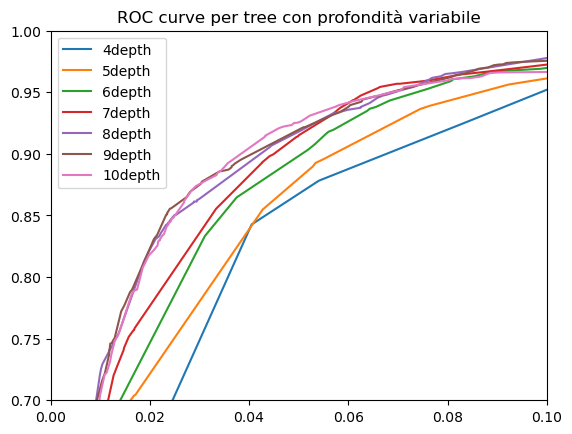

In [9]:
depth=np.arange(4,11)

for d in (depth):
    tree= DecisionTreeClassifier(max_depth=d, criterion='entropy')
    tree.fit(dati_train, det_train)
    
    det_prob = tree.predict_proba(dati_test)[:, 1]
    fpr, tpr, thresh = roc_curve(det_test, det_prob)
    plt.plot(fpr, tpr, label=str(d)+str("depth"))

plt.xlim(0,0.1)
plt.ylim(0.7,1)
plt.title("ROC curve per tree con profondità variabile")
plt.legend()
plt.show()
#il 7 sembra fare abbastanza bene

In [10]:
#controllo overfit

depth=np.arange(4,14)

compl_train=[]
cont_train=[]
compl_test=[]
cont_test=[]

train_accuracy=[]
test_accuracy=[]

for d in (depth):
    tree= DecisionTreeClassifier(max_depth=d, criterion='entropy')
    tree.fit(dati_train, det_train)
    
    det_pred=tree.predict(dati_test)
    cm_test = sklearn.metrics.confusion_matrix(det_test, det_pred)
    
    test_accuracy=np.append(test_accuracy, np.trace(cm_test) / np.sum(cm_test))
    
    completeness, contamination = completeness_contamination(det_pred, det_test)
    compl_test=np.append(compl_test, completeness)
    cont_test=np.append(cont_test, contamination)
    
    det_pred=tree.predict(dati_train)
    cm_train = sklearn.metrics.confusion_matrix(det_train, det_pred)
    train_accuracy=np.append(train_accuracy, np.trace(cm_train) / np.sum(cm_train))
    
    completeness, contamination = completeness_contamination(det_pred, det_train)
    compl_train=np.append(compl_train, completeness)
    cont_train=np.append(cont_train, contamination)
    
#calcolo accuracy con la confusion matrix: totale di oggetti che identifico bene/totale di oggetti

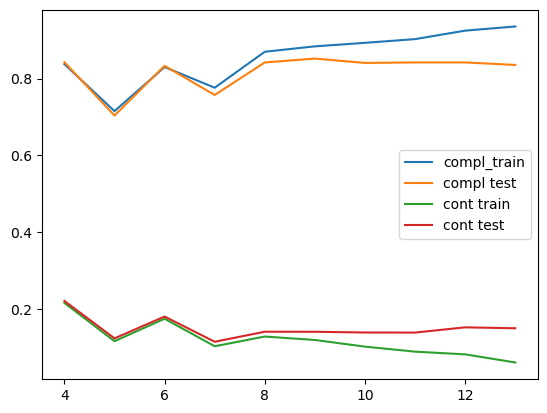

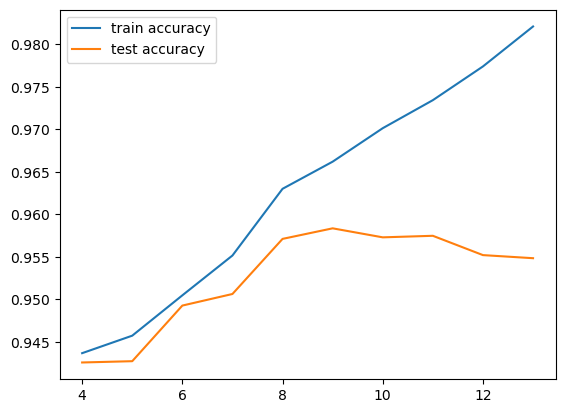

In [11]:
plt.plot(depth, compl_train, label="compl_train")
plt.plot(depth, compl_test, label="compl test")
plt.plot(depth, cont_train, label="cont train")
plt.plot(depth, cont_test, label="cont test")
plt.legend()
plt.show()

plt.plot(depth, train_accuracy, label="train accuracy")
plt.plot(depth, test_accuracy, label="test accuracy")
plt.legend()
plt.show()

In [12]:
#migliore è 6, dall'accuracy potrei scegliere anche 8 però guardando contamination e completeness sto già overfit

tree_best6=DecisionTreeClassifier(random_state=0, max_depth=6,criterion='entropy')

tree_best6.fit(dati_train, det_train)
det_pred=tree_best6.predict(dati_test)
completeness6, contamination6 = completeness_contamination(det_pred, det_test)

confusion6=sklearn.metrics.confusion_matrix(det_test, det_pred)

In [13]:
print("completeness d=6: ", completeness6)
print("contamination d=6: ", contamination6)
print("confusion matrix d=6: ") 
print(confusion6)

completeness d=6:  0.8326709893327756
contamination d=6:  0.18103270931907015
confusion matrix d=6: 
[[27339   880]
 [  800  3981]]


In [14]:
#proviamo con criterion=gini
depth=np.arange(4,14)

compl_train=[]
cont_train=[]
compl_test=[]
cont_test=[]

train_accuracy=[]
test_accuracy=[]

for d in (depth):
    tree= DecisionTreeClassifier(max_depth=d, criterion='gini')
    tree.fit(dati_train, det_train)
    
    det_pred=tree.predict(dati_test)
    cm_test = sklearn.metrics.confusion_matrix(det_test, det_pred)
    
    test_accuracy=np.append(test_accuracy, np.trace(cm_test) / np.sum(cm_test))
    
    completeness, contamination = completeness_contamination(det_pred, det_test)
    compl_test=np.append(compl_test, completeness)
    cont_test=np.append(cont_test, contamination)
    
    det_pred=tree.predict(dati_train)
    cm_train = sklearn.metrics.confusion_matrix(det_train, det_pred)
    train_accuracy=np.append(train_accuracy, np.trace(cm_train) / np.sum(cm_train))
    
    completeness, contamination = completeness_contamination(det_pred, det_train)
    compl_train=np.append(compl_train, completeness)
    cont_train=np.append(cont_train, contamination)

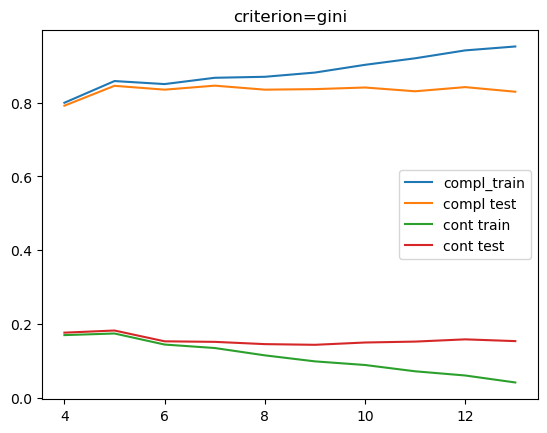

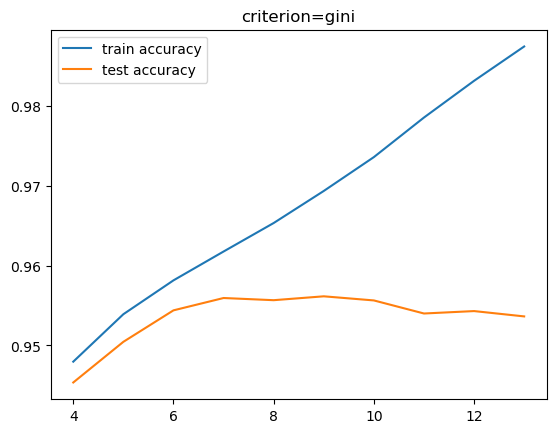

In [16]:
plt.plot(depth, compl_train, label="compl_train")
plt.plot(depth, compl_test, label="compl test")
plt.plot(depth, cont_train, label="cont train")
plt.plot(depth, cont_test, label="cont test")
plt.title("criterion=gini")
plt.legend()
plt.show()

plt.plot(depth, train_accuracy, label="train accuracy")
plt.plot(depth, test_accuracy, label="test accuracy")
plt.title("criterion=gini")
plt.legend()
plt.show()

In [17]:
tree_gini=DecisionTreeClassifier(random_state=0, max_depth=6,criterion='gini')

tree_gini.fit(dati_train, det_train)
det_pred=tree_gini.predict(dati_test)
completeness_g, contamination_g = completeness_contamination(det_pred, det_test)

confusion_g=sklearn.metrics.confusion_matrix(det_test, det_pred)

print("completeness per il test set e usando gini: ", completeness_g)
print("contamination per il test set e usando gini: ", contamination_g)
print("confusion matrix per il test set e usando gini: ") 
print(confusion_g)


completeness per il test set e usando gini:  0.835599247019452
contamination per il test set e usando gini:  0.1525243954179041
confusion matrix per il test set e usando gini: 
[[27500   719]
 [  786  3995]]


In [21]:
#provo con random forest

from sklearn.ensemble import RandomForestClassifier
depth=np.arange(4,18)

compl_train=[]
cont_train=[]
compl_test=[]
cont_test=[]

train_accuracy=[]
test_accuracy=[]

for d in (depth):
    tree= RandomForestClassifier(max_depth=d, criterion='entropy',n_jobs=-1)
    tree.fit(dati_train, det_train)
    
    det_pred=tree.predict(dati_test)
    cm_test = sklearn.metrics.confusion_matrix(det_test, det_pred)
    
    test_accuracy=np.append(test_accuracy, np.trace(cm_test) / np.sum(cm_test))
    
    completeness, contamination = completeness_contamination(det_pred, det_test)
    compl_test=np.append(compl_test, completeness)
    cont_test=np.append(cont_test, contamination)
    
    det_pred=tree.predict(dati_train)
    cm_train = sklearn.metrics.confusion_matrix(det_train, det_pred)
    train_accuracy=np.append(train_accuracy, np.trace(cm_train) / np.sum(cm_train))
    
    completeness, contamination = completeness_contamination(det_pred, det_train)
    compl_train=np.append(compl_train, completeness)
    cont_train=np.append(cont_train, contamination)

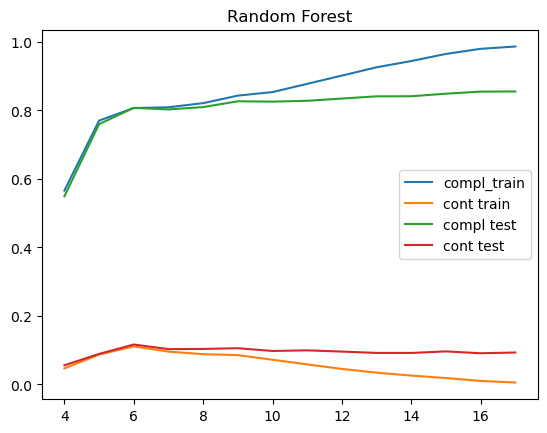

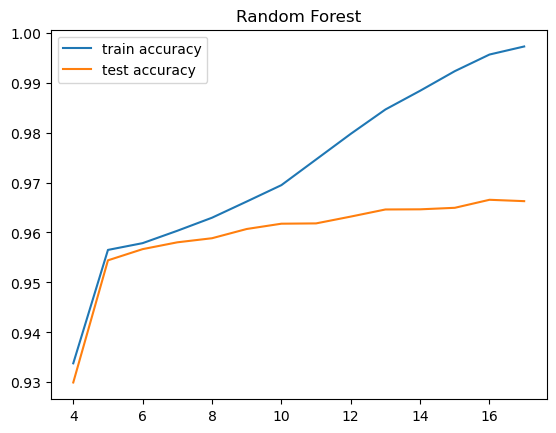

In [22]:
plt.plot(depth, compl_train, label="compl_train")
plt.plot(depth, cont_train, label="cont train")
plt.plot(depth, compl_test, label="compl test")
plt.plot(depth, cont_test, label="cont test")
plt.title("Random Forest")
plt.legend()
plt.show()

plt.plot(depth, train_accuracy, label="train accuracy")
plt.plot(depth, test_accuracy, label="test accuracy")
plt.title("Random Forest")
plt.legend()
plt.show()

In [25]:
tree_forest=RandomForestClassifier( max_depth=8,criterion='entropy')

tree_forest.fit(dati_train, det_train)
det_pred=tree_forest.predict(dati_test)
completeness_f, contamination_f = completeness_contamination(det_pred, det_test)

confusion_f=sklearn.metrics.confusion_matrix(det_test, det_pred)

print("completeness per il test set e usando random forest: ", completeness_f)
print("contamination per il test set e usando random forest: ", contamination_f)
print("confusion matrix per il test set e usando random forest: ") 
print(confusion_f)


completeness per il test set e usando random forest:  0.8144739594227149
contamination per il test set e usando random forest:  0.10379746835443038
confusion matrix per il test set e usando random forest: 
[[27768   451]
 [  887  3894]]


In [26]:
print("completeness per il test set e usando random forest: ", completeness_f)
print("contamination per il test set e usando random forest: ", contamination_f)

print("completeness per il test set e usando gini: ", completeness_g)
print("contamination per il test set e usando gini: ", contamination_g)

print("completeness d=6: ", completeness6)
print("contamination d=6: ", contamination6)

#forest è quello che fa meglio ma non così tanto

completeness per il test set e usando random forest:  0.8144739594227149
contamination per il test set e usando random forest:  0.10379746835443038
completeness per il test set e usando gini:  0.835599247019452
contamination per il test set e usando gini:  0.1525243954179041
completeness d=6:  0.8326709893327756
contamination d=6:  0.18103270931907015


In [27]:
#PROVO DIMENSIONALITY REDUCTION

from sklearn.decomposition import PCA

pca = PCA(n_components=2) 
pca.fit(dati) 

dati_reduced = pca.transform(dati)
evals = pca.explained_variance_ratio_
print(evals)
#non riesce a dividere bene, t-SNE ci mette troppo, per isomap è troppo grande

[9.99914482e-01 3.95487079e-05]
